In [123]:
import qutip as qt
import pandas as pd
import numpy as np

import os
import glob



In [124]:
def get_nearest_rotation(M):
    U, _, Vt = np.linalg.svd(M)
    R = U @ Vt
    return R


In [125]:

# list the folders in ../data
folders = glob.glob("../data/*")

folders = [f for f in folders if "1qb" in f]

# sort the folders by name
folders.sort()

folders


['../data/2025-05-27--15h-48m--2025-05-27--15h-48m_1qb_tomo_sagnac2_40mW_B_nominally_H',
 '../data/2025-05-27--15h-48m--2025-05-27--15h-49m_1qb_tomo_sagnac2_40mW_B_nominally_D',
 '../data/2025-05-27--15h-49m--2025-05-27--15h-50m_1qb_tomo_sagnac2_40mW_B_nominally_V',
 '../data/2025-05-27--15h-50m--2025-05-27--15h-50m_1qb_tomo_sagnac2_40mW_B_nominally_R',
 '../data/2025-05-27--15h-51m--2025-05-27--15h-51m_1qb_tomo_sagnac2_40mW_B_nominally_A',
 '../data/2025-05-27--15h-51m--2025-05-27--15h-52m_1qb_tomo_sagnac2_40mW_B_nominally_L',
 '../data/2025-05-27--15h-53m--2025-05-27--15h-53m_1qb_tomo_sagnac2_40mW_A_nominally_H',
 '../data/2025-05-27--15h-53m--2025-05-27--15h-54m_1qb_tomo_sagnac2_40mW_A_nominally_D',
 '../data/2025-05-27--15h-54m--2025-05-27--15h-55m_1qb_tomo_sagnac2_40mW_A_nominally_V',
 '../data/2025-05-27--15h-55m--2025-05-27--15h-55m_1qb_tomo_sagnac2_40mW_A_nominally_R',
 '../data/2025-05-27--15h-56m--2025-05-27--15h-56m_1qb_tomo_sagnac2_40mW_A_nominally_A',
 '../data/2025-05-27-

In [126]:
def extract_reconstructed_state(data, key="reconstructed_state"):

    matrix_11 = data[key][0][0]['real'] + 1j * data[key][0][0]['imag']
    matrix_12 = data[key][0][1]['real'] + 1j * data[key][0][1]['imag']
    matrix_21 = data[key][1][0]['real'] + 1j * data[key][1][0]['imag']
    matrix_22 = data[key][1][1]['real'] + 1j * data[key][1][1]['imag']

    matrix = [[matrix_11, matrix_12],
                [matrix_21, matrix_22]]
    return qt.Qobj(matrix, dims=[[2], [2]])



In [127]:
# for each folder, load the data in .../R/tomography_resutls.json and .../T/tomography_results.json

reconstructed_states = []

for folder in folders:
    last_part_of_folder = folder.split("/")[-1]

    # folder names like 2025-05-13--16h-29m--2025-05-13--16h-30m_1qb_tomo_sagnac2_40mW_B_nominally_H
    # extract the parameters from the folder name

    params = last_part_of_folder.split("_")
    nominal_state_name = params[-1]
    launcher = params[-3]
    laser_power = params[-4]

    R_file = os.path.join(folder, "R", "tomography_results.json")
    T_file = os.path.join(folder, "T", "tomography_results.json")

    if not os.path.exists(R_file) or not os.path.exists(T_file):
        print(f"Skipping {folder} because one of the files does not exist")
        continue

    R_data = pd.read_json(R_file)
    T_data = pd.read_json(T_file)

    rho_R = extract_reconstructed_state(R_data)
    rho_T = extract_reconstructed_state(T_data)
    
    target_state = extract_reconstructed_state(T_data, key="target_state")

    reconstructed_states.append({
        "folder": folder,
        "nominal_state_name": nominal_state_name,
        "launcher": launcher,
        "laser_power": laser_power,
        "reconstructed_state_T": rho_T,
        "reconstructed_state_R": rho_R,
        "target_state": target_state
    })

reconstructed_states[-1]['reconstructed_state_T']



Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.50911795+0.j         -0.24782709+0.43416425j]
 [-0.24782709-0.43416425j  0.49088205+0.j        ]]

In [128]:
def density_to_bloch_coords(rho):
    x = np.real((rho * qt.Qobj([[0, 1], [1, 0]])).tr())  # ⟨σx⟩
    y = np.real((rho * qt.Qobj([[0, -1j], [1j, 0]])).tr())  # ⟨σy⟩
    z = np.real((rho * qt.Qobj([[1, 0], [0, -1]])).tr())  # ⟨σz⟩
    return [x, y, z]


bloch = density_to_bloch_coords(reconstructed_states[0]['reconstructed_state_T'])
bloch

[-0.040225829395192, -0.048667817863340006, 0.9882706774366371]

In [129]:
# add the bloch coordinates to the reconstructed states
for state in reconstructed_states:
    bloch_coords_T = density_to_bloch_coords(state['reconstructed_state_T'])
    state['bloch_coords_T'] = bloch_coords_T
    bloch_coords_R = density_to_bloch_coords(state['reconstructed_state_R'])
    state['bloch_coords_R'] = bloch_coords_R

reconstructed_states[0]['bloch_coords_T']

[-0.040225829395192, -0.048667817863340006, 0.9882706774366371]

In [130]:
# b = qt.Bloch()
# bloch_coords_T = state['bloch_coords_T']
# b.add_points(bloch_coords_T)

# b.add_annotation(bloch_coords_T, state['launcher'] + "T")

# bloch_coords_R = state['bloch_coords_R']
# b.add_points(bloch_coords_R)

# b.add_annotation(bloch_coords_R, state['launcher'] + "R")

# Add points
for state in reconstructed_states:
    # new bloch sphere for each state
    b = qt.Bloch()
    b.view = [180, 90]
    # make the image bigger
    b.make_sphere()
    bloch_coords_T = state['bloch_coords_T']
    b.add_points(bloch_coords_T)
    print(state["nominal_state_name"])
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8)
    bloch_coords_R = state['bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8)

    # Display
    # b.show()

H
D
V
R
A
L
H
D
V
R
A
L


# Launcher B

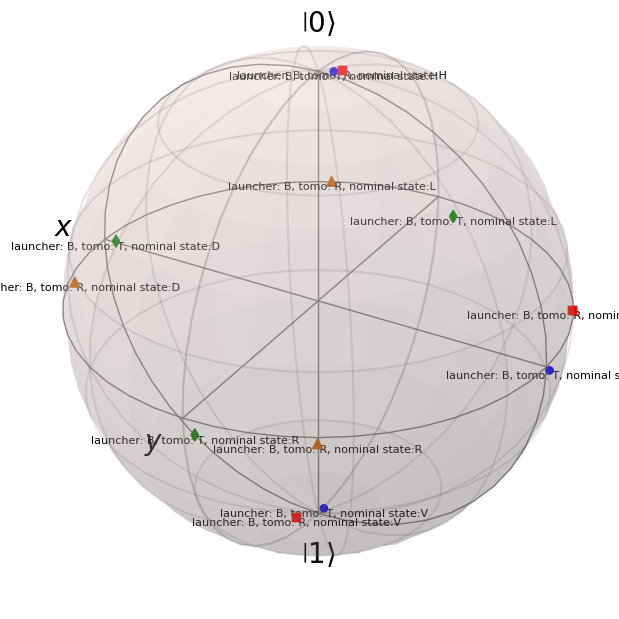

In [131]:
b = qt.Bloch()
b.view = [30, 30]
b.make_sphere()

for state in reconstructed_states[-12:-6]:
    bloch_coords_T = state['bloch_coords_T']
    b.add_points(bloch_coords_T)
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')
    bloch_coords_R = state['bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')

    # Display, ensuring the annotations are not cut off
b.fig.set_size_inches(6, 6)

b.show()


## Compensate the imperfect tomography

In [132]:
e_h_prime_b_t = reconstructed_states[0]['bloch_coords_T']
e_h_prime_b_r = reconstructed_states[0]['bloch_coords_R']

e_d_prime_b_t = reconstructed_states[1]['bloch_coords_T']
e_d_prime_b_r = reconstructed_states[1]['bloch_coords_R']

e_v_prime_b_t = reconstructed_states[2]['bloch_coords_T']
e_v_prime_b_r = reconstructed_states[2]['bloch_coords_R']

e_r_prime_b_t = reconstructed_states[3]['bloch_coords_T']
e_r_prime_b_r = reconstructed_states[3]['bloch_coords_R']

e_a_prime_b_t = reconstructed_states[4]['bloch_coords_T']
e_a_prime_b_r = reconstructed_states[4]['bloch_coords_R']

e_l_prime_b_t = reconstructed_states[5]['bloch_coords_T']
e_l_prime_b_r = reconstructed_states[5]['bloch_coords_R']

e_z_prime_b_t = (e_h_prime_b_t - np.array(e_v_prime_b_t)) / 2
e_x_prime_b_t = (e_d_prime_b_t - np.array(e_a_prime_b_t)) / 2
e_y_prime_b_t = (e_r_prime_b_t - np.array(e_l_prime_b_t)) / 2

e_z_prime_b_r = (e_h_prime_b_r - np.array(e_v_prime_b_r)) / 2
e_x_prime_b_r = (e_d_prime_b_r - np.array(e_a_prime_b_r)) / 2
e_y_prime_b_r = (e_r_prime_b_r - np.array(e_l_prime_b_r)) / 2

bloch_rotation_r = get_nearest_rotation(np.vstack((e_x_prime_b_t, e_y_prime_b_t, e_z_prime_b_t,)).transpose())
bloch_rotation_t = get_nearest_rotation(np.vstack((e_x_prime_b_r, e_y_prime_b_r, e_z_prime_b_r,)).transpose())

bloch_rotation_r, bloch_rotation_t

(array([[ 0.99985739,  0.0146699 , -0.00836679],
        [-0.01470901,  0.99988109, -0.00463252],
        [ 0.00829783,  0.00475493,  0.99995427]]),
 array([[ 0.88337015, -0.4662638 , -0.0474894 ],
        [ 0.46451711,  0.88449391, -0.04352444],
        [ 0.06229795,  0.01638855,  0.99792303]]))

In [133]:
undo_t = np.linalg.inv(bloch_rotation_t)
undo_r = np.linalg.inv(bloch_rotation_r)

undo_t, undo_r


(array([[ 0.88337015,  0.46451711,  0.06229795],
        [-0.4662638 ,  0.88449391,  0.01638855],
        [-0.0474894 , -0.04352444,  0.99792303]]),
 array([[ 0.99985739, -0.01470901,  0.00829783],
        [ 0.0146699 ,  0.99988109,  0.00475493],
        [-0.00836679, -0.00463252,  0.99995427]]))

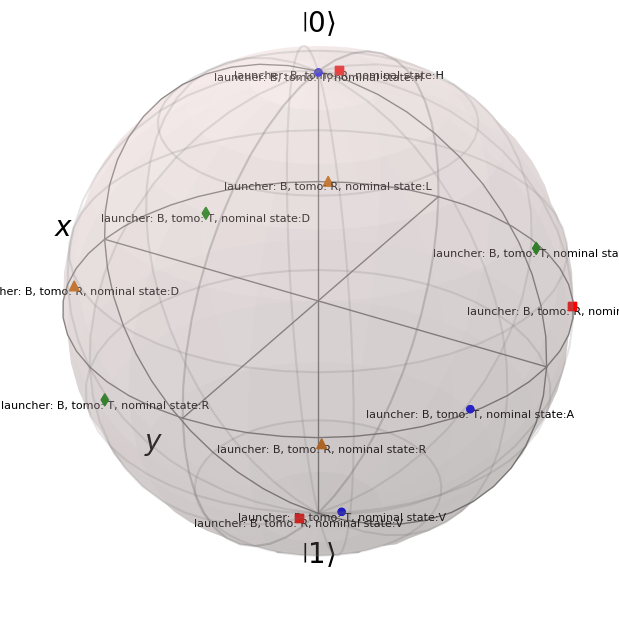

In [134]:
# Apply the undo rotation to the reconstructed states
for state in reconstructed_states[-12:-6]:
    state['corrected_bloch_coords_T'] = undo_t @ np.array(state['bloch_coords_T']).transpose()
    state['corrected_bloch_coords_R'] = undo_r @ np.array(state['bloch_coords_R']).transpose()
# Plot the bloch sphere again with the rotated states
b = qt.Bloch()
b.view = [30, 30]
b.make_sphere()
for state in reconstructed_states[-12:-6]:
    bloch_coords_T = state['corrected_bloch_coords_T']
    b.add_points(bloch_coords_T)
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')
    bloch_coords_R = state['corrected_bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')
# Display, ensuring the annotations are not cut off
b.fig.set_size_inches(6, 6)
b.show()

# Launcher A

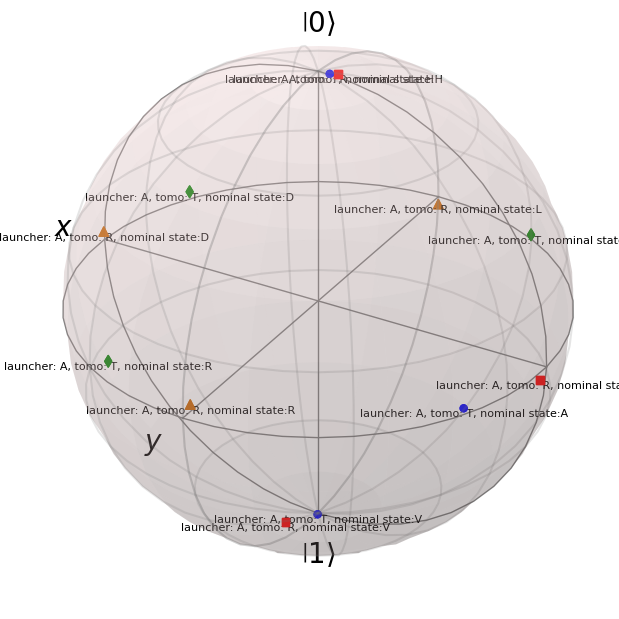

In [135]:
b = qt.Bloch()
b.view = [30, 30]
b.make_sphere()

for state in reconstructed_states[-6:]:
    bloch_coords_T = state['bloch_coords_T']
    b.add_points(bloch_coords_T)
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')
    bloch_coords_R = state['bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')

    # Display, ensuring the annotations are not cut off
b.fig.set_size_inches(6, 6)

b.show()


## Compensate the imperfect tomography

In [136]:
e_h_prime_b_t = reconstructed_states[0+6]['bloch_coords_T']
e_h_prime_b_r = reconstructed_states[0+6]['bloch_coords_R']

e_d_prime_b_t = reconstructed_states[1+6]['bloch_coords_T']
e_d_prime_b_r = reconstructed_states[1+6]['bloch_coords_R']

e_v_prime_b_t = reconstructed_states[2+6]['bloch_coords_T']
e_v_prime_b_r = reconstructed_states[2+6]['bloch_coords_R']

e_r_prime_b_t = reconstructed_states[3+6]['bloch_coords_T']
e_r_prime_b_r = reconstructed_states[3+6]['bloch_coords_R']

e_a_prime_b_t = reconstructed_states[4+6]['bloch_coords_T']
e_a_prime_b_r = reconstructed_states[4+6]['bloch_coords_R']

e_l_prime_b_t = reconstructed_states[5+6]['bloch_coords_T']
e_l_prime_b_r = reconstructed_states[5+6]['bloch_coords_R']

e_z_prime_b_t = (e_h_prime_b_t - np.array(e_v_prime_b_t)) / 2
e_x_prime_b_t = (e_d_prime_b_t - np.array(e_a_prime_b_t)) / 2
e_y_prime_b_t = (e_r_prime_b_t - np.array(e_l_prime_b_t)) / 2

e_z_prime_b_r = (e_h_prime_b_r - np.array(e_v_prime_b_r)) / 2
e_x_prime_b_r = (e_d_prime_b_r - np.array(e_a_prime_b_r)) / 2
e_y_prime_b_r = (e_r_prime_b_r - np.array(e_l_prime_b_r)) / 2

bloch_rotation_r = np.vstack((e_x_prime_b_t, e_y_prime_b_t, e_z_prime_b_t,)).transpose()
bloch_rotation_r = np.vstack((e_x_prime_b_r, e_y_prime_b_r, e_z_prime_b_r,)).transpose()

bloch_rotation_r, bloch_rotation_t

(array([[ 0.98258749, -0.00449609, -0.0634695 ],
        [ 0.00665293,  0.9784729 , -0.09921267],
        [ 0.0541556 ,  0.03764897,  0.98096653]]),
 array([[ 0.88337015, -0.4662638 , -0.0474894 ],
        [ 0.46451711,  0.88449391, -0.04352444],
        [ 0.06229795,  0.01638855,  0.99792303]]))

In [137]:



undo_t = undo_rotation(bloch_rotation_t)
undo_r = undo_rotation(bloch_rotation_r)

undo_t, undo_r


(array([[ 0.88337015,  0.46451711,  0.06229795],
        [-0.4662638 ,  0.88449391,  0.01638855],
        [-0.0474894 , -0.04352444,  0.99792303]]),
 array([[ 0.99819263,  0.00435222,  0.05993766],
        [-0.00851135,  0.99755876,  0.06931151],
        [-0.05948968, -0.06969639,  0.99579285]]))

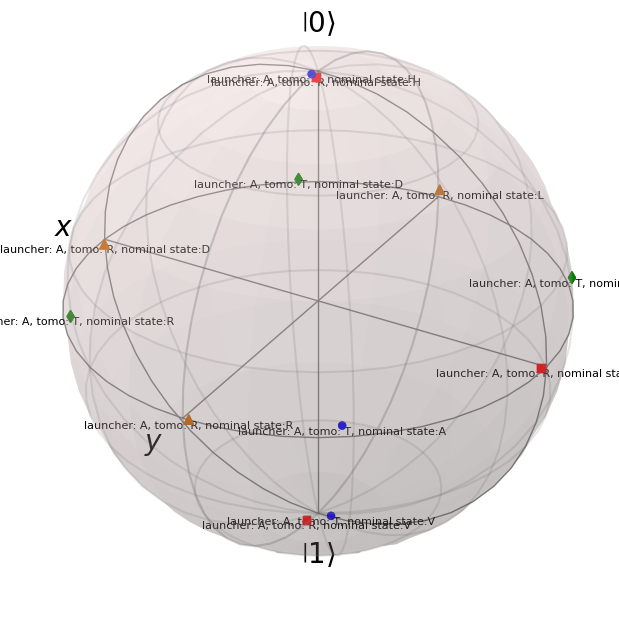

In [138]:
# Apply the undo rotation to the reconstructed states
for state in reconstructed_states[-6:]:
    state['corrected_bloch_coords_T'] = undo_t @ np.array(state['bloch_coords_T']).transpose()
    state['corrected_bloch_coords_R'] = undo_r @ np.array(state['bloch_coords_R']).transpose()
# Plot the bloch sphere again with the rotated states
b = qt.Bloch()
b.view = [30, 30]
b.make_sphere()
for state in reconstructed_states[-6:]:
    bloch_coords_T = state['corrected_bloch_coords_T']
    b.add_points(bloch_coords_T)
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')
    bloch_coords_R = state['corrected_bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8, verticalalignment='top')
# Display, ensuring the annotations are not cut off
b.fig.set_size_inches(6, 6)
b.show()

## Compensate the 

In [139]:
# for each of the launcher B states, find the phase angle of the state in the T tomography
def phase_angle(state):
    if state['launcher'] == "B":
        bloch_coords = state['bloch_coords_T']
    elif state['launcher'] == "A":
        bloch_coords = state['bloch_coords_R']
    else:
        raise ValueError("Launcher must be either A or B")
    # get the x and y coordinates
    x = bloch_coords[0]
    y = bloch_coords[1]
    # calculate the angle
    angle = np.arctan2(y, x)
    
    return angle

# get the phase angle for each state
phase_angles = []
for state in reconstructed_states:
    angle = phase_angle(state)
    phase_angles.append({
        "folder": state['folder'],
        "nominal_state_name": state['nominal_state_name'],
        "launcher": state['launcher'],
        "laser_power": state['laser_power'],
        "phase_angle": angle,
        "bloch_coords_T_x": state['bloch_coords_T'][0] *180 / np.pi,
        "bloch_coords_T_y": state['bloch_coords_T'][1]*180 / np.pi,
        "bloch_coords_R_x": state['bloch_coords_R'][0]*180 / np.pi,
        "bloch_coords_R_y": state['bloch_coords_R'][1]*180 / np.pi,
    })

# convert to dataframe
phase_angles_df = pd.DataFrame(phase_angles)

# add the phase angle in degrees
phase_angles_df['phase_angle_degrees'] = (phase_angles_df['phase_angle'] * 180 / np.pi) % 360

# add the intended phase angle based on the nominal state name
def intended_phase_angle(nominal_state_name):
    if nominal_state_name == "D":
        return 0
    elif nominal_state_name == "R":
        return 90
    elif nominal_state_name == "A":
        return 180
    elif nominal_state_name == "L":
        return 270

phase_angles_df['intended_phase_angle'] = phase_angles_df['nominal_state_name'].apply(intended_phase_angle)

# add the phase angle difference
phase_angles_df['phase_angle_difference'] = (phase_angles_df['phase_angle_degrees'] - phase_angles_df['intended_phase_angle']) % 360


phase_angles_df

,folder,nominal_state_name,launcher,laser_power,phase_angle,bloch_coords_T_x,bloch_coords_T_y,bloch_coords_R_x,bloch_coords_R_y,phase_angle_degrees,intended_phase_angle,phase_angle_difference
0,../data/2025-05-27--15h-48m--2025-05-27--15h-4...,H,B,40mW,-2.261511,-2.304770,-2.788461,-2.949275,-5.129018,230.424955,NaN,NaN
1,../data/2025-05-27--15h-48m--2025-05-27--15h-4...,D,B,40mW,-0.067037,56.717393,-3.807895,49.327268,24.268232,356.159037,0.0,356.159037
2,../data/2025-05-27--15h-49m--2025-05-27--15h-5...,V,B,40mW,-1.744563,-0.365873,-2.084309,2.956446,5.136637,260.043900,NaN,NaN
3,../data/2025-05-27--15h-50m--2025-05-27--15h-5...,R,B,40mW,1.615657,-2.545619,56.706384,-28.154823,48.978303,92.570352,90.0,2.570352
4,../data/2025-05-27--15h-51m--2025-05-27--15h-5...,A,B,40mW,-3.103998,-57.032560,-2.145129,-50.325351,-26.758807,182.154014,180.0,2.154014
5,../data/2025-05-27--15h-51m--2025-05-27--15h-5...,L,B,40mW,-1.644726,-4.221344,-56.995584,25.254083,-50.226773,265.764156,270.0,355.764156
6,../data/2025-05-27--15h-53m--2025-05-27--15h-5...,H,A,40mW,-2.338567,-2.271685,-1.088793,-3.176505,-3.290511,226.009959,NaN,NaN
7,../data/2025-05-27--15h-53m--2025-05-27--15h-5...,D,A,40mW,0.036250,50.419948,-26.362390,56.062588,2.033148,2.076960,0.0,2.076960
8,../data/2025-05-27--15h-54m--2025-05-27--15h-5...,V,A,40mW,1.101485,-0.347530,0.838910,4.096564,8.078423,63.110459,NaN,NaN
9,../data/2025-05-27--15h-55m--2025-05-27--15h-5...,R,A,40mW,1.589315,23.119253,50.485048,-1.033909,55.825453,91.061019,90.0,1.061019


In [140]:
# Now for the reflected paths:
def phase_angle(state):
    if state['launcher'] == "B":
        bloch_coords = state['bloch_coords_R']
    elif state['launcher'] == "A":
        bloch_coords = state['bloch_coords_T']
    else:
        raise ValueError("Launcher must be either A or B")
    # get the x and y coordinates
    x = bloch_coords[0]
    y = bloch_coords[1]
    # calculate the angle
    angle = np.arctan2(y, x)
    
    return angle

# get the phase angle for each state
phase_angles = []
for state in reconstructed_states:
    angle = phase_angle(state)
    phase_angles.append({
        "folder": state['folder'],
        "nominal_state_name": state['nominal_state_name'],
        "launcher": state['launcher'],
        "laser_power": state['laser_power'],
        "phase_angle": angle,
        "bloch_coords_T_x": state['bloch_coords_T'][0] *180 / np.pi,
        "bloch_coords_T_y": state['bloch_coords_T'][1]*180 / np.pi,
        "bloch_coords_R_x": state['bloch_coords_R'][0]*180 / np.pi,
        "bloch_coords_R_y": state['bloch_coords_R'][1]*180 / np.pi,
    })

# convert to dataframe
phase_angles_df = pd.DataFrame(phase_angles)

# add the phase angle in degrees
phase_angles_df['phase_angle_degrees'] = (phase_angles_df['phase_angle'] * 180 / np.pi) % 360

# add the intended phase angle based on the nominal state name
def intended_phase_angle(nominal_state_name):
    if nominal_state_name == "D":
        return 0
    elif nominal_state_name == "R":
        return 90
    elif nominal_state_name == "A":
        return 180
    elif nominal_state_name == "L":
        return 270

phase_angles_df['intended_phase_angle'] = phase_angles_df['nominal_state_name'].apply(intended_phase_angle)

# add the phase angle difference
phase_angles_df['phase_angle_difference'] = (phase_angles_df['phase_angle_degrees'] - phase_angles_df['intended_phase_angle']) % 360


phase_angles_df.to_csv("phase_angles.csv", index=False)